### Cts-Genome Coverage Plots

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dt = datetime.today().strftime(format='%d-%m-%Y')

In [7]:
#uniqueness in directory and file names is assumed for all analyses
sars_dir = "SARS-CoV-2"
home_dir = os.getenv('HOME')
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

In [8]:
home_dir = '/home/douso/SarsGenomics/Processed'
df_cov = pd.read_excel(f'{parent_dir}/KnowledgeBrief/metadata-seq-MS-ILL-ONT_uptoseq20_28-10-2021.xlsx', usecols=['S_NUM', 'G_COV'])

In [9]:
df_cov

,S_NUM,G_COV
0,COVC03617,98.6
1,COVC03665,97.5
2,COVC03696,98.7
3,COVC03723,98.9
4,COVC03813,97.9
...,...,...
1803,COVM01305,95.1
1804,COVM01306,7.6
1805,COVM01307,91.9
1806,COVM01308,96.0


In [10]:
samp_names = list(df_cov['S_NUM'])

In [11]:
df_Cts = pd.read_excel(f"{glob.glob(f'{parent_dir}/**/Outputs', recursive=True)[0]}/runsheet-cts.xlsx")[['Sample_Name', 'Well_Position', 'Ct_Mean', 'Dt_Run']]
# df_nhrl_Cts = pd.read_excel('/home/douso/Documents/RunSheets/Cts/NHRL-cts.xlsx')
# df_Cts = df_covc_Cts.append(df_nhrl_Cts)

In [12]:
df_ct_cov = (df_Cts.merge(df_cov, how='inner', left_on='Sample_Name', 
            right_on='S_NUM').drop('S_NUM',axis=1).sort_values('Ct_Mean').dropna())#[df_Cts['Sample_Name'].isin(samp_names)]

In [13]:
# df_ct_cov.to_excel('/home/douso/Documents/RunSheets/Cts/cts-cov.xlsx', index=False, float_format='%.0f')

In [26]:
mask1 = df_ct_cov['G_COV'] >= 80
mask2 = df_ct_cov['Ct_Mean'] > 30
mask3 = df_ct_cov['Ct_Mean'] <= 35
mask4 = df_ct_cov['G_COV'] < 80
mask5 = df_ct_cov['Ct_Mean'] <= 30
mask6 = df_ct_cov['Ct_Mean'] > 35
# mask7 = df_ct_cov['G_COV'] > 80
# mask8 = df_ct_cov['G_COV'] < 80


above30below35_pass = df_ct_cov[mask1 & mask2 & mask3 == True].shape[0]
above30below35_fail = df_ct_cov[mask4 & mask2 & mask3 == True].shape[0]
below30above80_pass = df_ct_cov[mask5 & mask1 == True].shape[0]
below30below80_fail = df_ct_cov[mask5 & mask4 == True].shape[0]
above35above80_pass = df_ct_cov[mask6 & mask1 == True].shape[0]
above35below80_fail = df_ct_cov[mask6 & mask4 == True].shape[0]

print(below30above80_pass, below30below80_fail)
print(above35above80_pass, above35below80_fail)

722 111
43 93


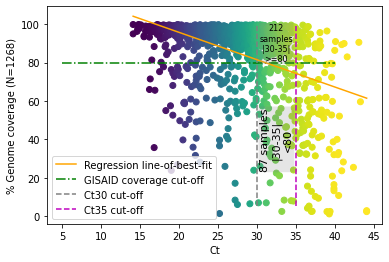

In [28]:
fig,ax = plt.subplots()
lr = LinearRegression()
lr.fit(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1), df_ct_cov['G_COV'])

y_predicted = lr.predict(np.array(df_ct_cov['Ct_Mean']).reshape(-1, 1))

plt.plot(df_ct_cov['Ct_Mean'], y_predicted, color='orange', label='Regression line-of-best-fit')

plt.scatter(df_ct_cov['Ct_Mean'], df_ct_cov['G_COV'], 
            c=np.linspace(0, 40, len(df_ct_cov['Ct_Mean'])), 
            cmap='viridis')#viridis#RdYlBu ,edgecolors='#FFF5EE'
# plt.colorbar(label='Cts', location='bottom')
ax.text(32.5, 90, s=f'{above30below35_pass}\nsamples\n|30-35|\n>=80', 
        ha="center", va="center", rotation=0, fontsize=8, 
        bbox=dict(boxstyle="round,pad=0.05", fc="gray", alpha=0.2, ec="b", lw=0))
ax.text(32.5, 40, s=f'{above30below35_fail} samples\n|30-35|\n<80', 
        ha="center", va="center", rotation=90, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.1", fc="gray", alpha=0.2, ec="b", lw=0))
plt.xlabel('Ct')
plt.ylabel(f'% Genome coverage (N={len(df_ct_cov["Ct_Mean"])})')
plt.hlines(80, 5, 40, linestyles='dashdot', colors='g', label='GISAID coverage cut-off')
plt.vlines(30, 5, 99, linestyles='dashed', colors='gray', label='Ct30 cut-off')
plt.vlines(35, 5, 99, linestyles='dashed', colors='m', label='Ct35 cut-off')
plt.legend()
# fig.savefig(f"{glob.glob(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/report-CTs_{dt}.svg")
plt.show()

In [19]:
df_ct_cov[mask4 & mask2 & mask3 == True].sort_values('G_COV')

,Sample_Name,Well_Position,Ct_Mean,Dt_Run,G_COV
369,COVC19687,G09,33.2,2020-11-11 17:22:39,2.4
363,COVC19546,C10,31.2,2020-11-10 19:26:52,6.9
910,COVC24461,A11,30.2,2021-09-20 13:35:04,6.9
507,COVC21291,A05,34.7,2020-11-17 14:10:38,7.8
952,COVC24483,A02,34.4,2021-09-24 20:14:57,8.0
...,...,...,...,...,...
1212,COVC24655,A08,30.3,2021-10-06 16:03:59,77.6
466,COVC20819,A06,32.2,2020-11-13 21:00:13,79.2
414,COVC20317,F01,30.3,2020-11-12 20:01:40,79.3
956,COVC24488,A07,34.7,2021-09-24 20:14:57,79.8


In [22]:
df_ct_cov[mask1 == True]#.sort_values('G_COV')

,Sample_Name,Well_Position,Ct_Mean,Dt_Run,G_COV
1142,COVM00721,G05,14.1,2021-10-06 12:22:00,99.9
779,COVC24050,B11,14.1,2021-08-06 19:38:50,95.0
957,COVC24516,C11,14.6,2021-09-24 20:14:57,96.3
4,COVC03813,A07,14.7,2020-07-13 12:15:23,97.9
1151,COVM00673,C05,14.8,2021-10-06 12:22:00,99.9
...,...,...,...,...,...
550,COVC22973,B03,40.1,2021-02-08 16:39:23,91.0
566,COVC23192,A11,40.9,2021-02-13 13:21:28,89.4
536,COVC22829,B03,41.2,2021-01-13 12:59:21,90.0
565,COVC23189,A08,41.6,2021-02-13 13:21:28,83.0


In [22]:
df_ct_cov[mask1 == True]#.sort_values('G_COV')

,Sample_Name,Well_Position,Ct_Mean,Dt_Run,G_COV
1142,COVM00721,G05,14.1,2021-10-06 12:22:00,99.9
779,COVC24050,B11,14.1,2021-08-06 19:38:50,95.0
957,COVC24516,C11,14.6,2021-09-24 20:14:57,96.3
4,COVC03813,A07,14.7,2020-07-13 12:15:23,97.9
1151,COVM00673,C05,14.8,2021-10-06 12:22:00,99.9
...,...,...,...,...,...
550,COVC22973,B03,40.1,2021-02-08 16:39:23,91.0
566,COVC23192,A11,40.9,2021-02-13 13:21:28,89.4
536,COVC22829,B03,41.2,2021-01-13 12:59:21,90.0
565,COVC23189,A08,41.6,2021-02-13 13:21:28,83.0
